In [15]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [16]:
# Image directories
train_dir = "images/training/"
test_dir = "images/test/"

Fungsi untuk standarisasi gambar

In [17]:
def standarized_input(image):
    # mengubah warna gambar ke RGB
    std_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # mengubah ukuran gambar ke 1100x600
    std_img = cv2.resize(std_img, (1100,600))

    return std_img

Fungsi memuat dataset gambar

In [18]:
def load_dataset(img_dir, img_ext = 'jpg'):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        label = str(dir).split('\\')[-1]
        for file in dir.glob('*.' + img_ext):
            img = cv2.imread(file)
            img = standarized_input(img)

            if not img is None:
                img_list.append((img, label))

    return img_list

Membuat dataset training

In [19]:
train_img = load_dataset(train_dir)

Fungsi mengonversi label menjadi data numerik

In [20]:
def label_encoder(label):
    # melakuakan encoding label
    # 0 = night || 1 = day

    num_val = 0

    if(label == 'day'):
        num_val = 1
    
    return num_val

Fungsi mengekstrak histogram dari gambar

In [21]:
def extract_histogram(image):
    # mengambil histogram dari gambar
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # melakukan normalisasi histogram
    hist_norm = cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)

    return hist_norm

Fungsi mengekstrak rata-rata intensitas piksel dibawah dan diatas ambang batas

In [22]:
def extract_avg_intensity(img, threshold=40):

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = extract_histogram(img)

    avg_low_hist = [np.mean(hist[:threshold])]

    avg_high_hist = [np.mean(hist[threshold:])]

    return avg_low_hist, avg_high_hist

Fungsi untuk mencari rata-rata warna gambar

In [23]:
def extract_avg_color(img):
    avg_color = cv2.mean(img)[:3]
    return avg_color

In [24]:

rand_num = np.random.randint(0, len(train_img))

AVERAGE LOW INTENSITY HISTOGRAM:  [48.820442]
AVERAGE HIGH INTENSITY HISTOGRAM:  [2.9705458]
AVERAGE COLOR:  (37.923153030303034, 31.19678787878788, 21.668977272727275)


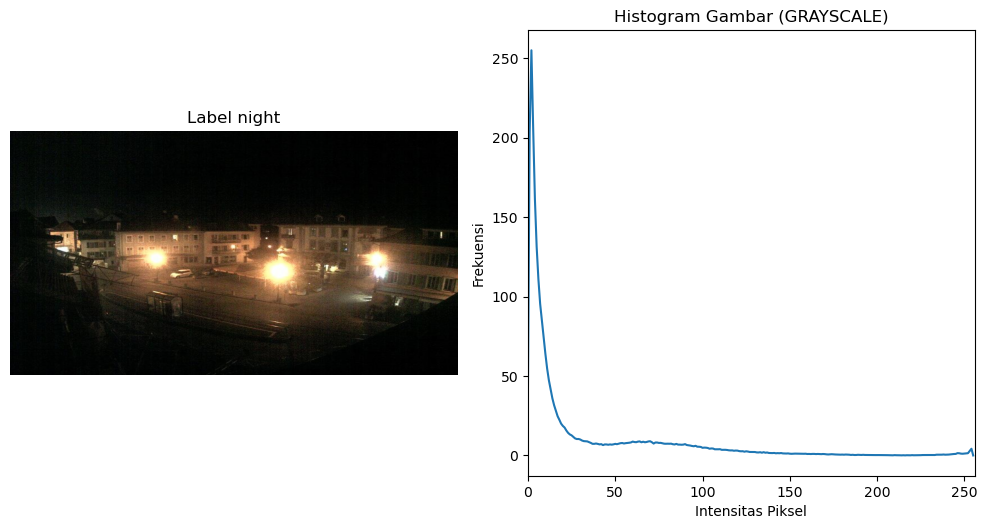

In [25]:
img = train_img[rand_num]

img_gray = cv2.cvtColor(img[0], cv2.COLOR_RGB2GRAY)
hist = extract_histogram(img_gray)
avg_low_hist, avg_high_hist = extract_avg_intensity(img[0])
avg_color = extract_avg_color(img[0])

print("AVERAGE LOW INTENSITY HISTOGRAM: ", avg_low_hist)
print("AVERAGE HIGH INTENSITY HISTOGRAM: ", avg_high_hist)
print("AVERAGE COLOR: ", avg_color)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(img[0])
plt.title("Label " + str(img[1]))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.plot(hist)
plt.title('Histogram Gambar (GRAYSCALE)')
plt.xlabel('Intensitas Piksel')
plt.ylabel('Frekuensi')
plt.xlim([0, 256])

plt.tight_layout()
plt.show()

In [26]:
def preprocess(img_list):
    # fitur 1
    low_intensity_list = []

    # fitur 2
    high_intensity_list = []

    # fitur 3
    avg_color_list = []
    labels = []

    for img in img_list:
        avg_low_hist, avg_high_hist = extract_avg_intensity(img[0])
        avg_color = extract_avg_color(img[0])
        encoded_label = label_encoder(img[1])

        avg_color_list.append(avg_color)
        low_intensity_list.append(avg_low_hist)
        high_intensity_list.append(avg_high_hist)
        labels.append(encoded_label)

    # Stack the data and create a DataFrame
    data = np.column_stack((low_intensity_list, high_intensity_list, avg_color_list, labels))
    
    df = pd.DataFrame(data, columns=['LOW_INTENSITY', 'HIGH_INTENSITY', 'AVG_RED', "AVG_GREEN", 'AVG_BLUE', 'LABEL'])

    return df

In [27]:
# melakukan preprocessing pada data train
train_std_img_list = preprocess(train_img)

In [28]:
train_std_img_list.head()

,LOW_INTENSITY,HIGH_INTENSITY,AVG_RED,AVG_GREEN,AVG_BLUE,LABEL
0,0.776452,27.475464,147.139626,168.653738,170.143197,1.0
1,0.244670,27.164980,150.587386,177.965462,190.923742,1.0
2,61.504883,53.665451,120.815918,116.304661,109.432761,1.0
3,0.044195,34.396664,148.759924,177.651289,198.698012,1.0
4,20.803226,56.263798,94.435568,95.322468,90.043571,1.0


In [29]:
# mengambil data testing
test_img = load_dataset(test_dir)

# melakukan preprocessing pada data testing
test_std_img_list = preprocess(test_img)

In [30]:
test_std_img_list.head()

,LOW_INTENSITY,HIGH_INTENSITY,AVG_RED,AVG_GREEN,AVG_BLUE,LABEL
0,0.792506,35.451134,145.056398,173.794970,193.017133,1.0
1,25.966162,89.521553,143.715144,138.819574,130.403445,1.0
2,0.004970,30.368845,149.358903,177.186733,200.542183,1.0
3,0.684390,26.504154,152.744050,172.727300,185.579526,1.0
4,1.143007,24.815365,151.399774,170.906732,181.013533,1.0


In [31]:
from sklearn.svm import SVC

X_train = train_std_img_list.iloc[:, :-1].values
y_train = train_std_img_list.iloc[:, -1].values
X_test = test_std_img_list.iloc[:, :-1].values
y_test = test_std_img_list.iloc[:, -1].values

model = SVC()
model.fit(X_train, y_train)

SVC()

In [32]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)

y_test_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)

print(f'Accuracy on train: {acc_train}')
print(f'Accuracy on test: {acc_test}')

Accuracy on train: 0.9875
Accuracy on test: 0.93125
